Import knihoven pro praci se zvukem. Pro model budeme pouzivat knihovnu ```PyTorch```.

In [23]:
import torch, torchaudio
import numpy as np
import matplotlib.pyplot as plt
import soundfile
import librosa

In [5]:
import os
from os import walk

Priprava transformace Waveform --> STFT spectrogram podle paramateru:

```n_fft``` - rozmer okna STFT;

```hop_length``` - tzv. hop-size - v podstate nastaví posunutí pro transformace dalšího okna.

In [6]:
n_fft = 400
hop_length = 200

# Define transform
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=torch.hann_window,
    center=True,
    pad_mode="reflect",
    power=None
)

Zadefinujeme take inverzni transofrmace se stejnymi parametry pro ziskani Waveform 

In [7]:
inverse_spectrogram = torchaudio.transforms.InverseSpectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=torch.hann_window,
    center=True,
    pad_mode="reflect"
).cuda()

Ted' zadefinujeme fukci pro pripravu dat, ktera perevezme na vstup STFT z jedne cele audio nahravky(jeden audio file), rozdeli ho na odpovidajici pary:

``(padd + 13)`` --> ``inverse(13 + 3_pred)``, 

a ulozi tyto polozky v batchech po 8.

In [8]:
def make_sound_stft_batches(stft):
    
    batches = torch.Tensor([])
    ref_batches = torch.Tensor([])
    
    batch = torch.Tensor([])
    ref_batch = torch.Tensor([])
    
    for i in range(0, stft.shape[0], 16): 
        input_windows = stft[i:i+13]
        reference_windows = stft[i:i+16]
        #print(input_windows.shape)
        x = torch.view_as_real(torch.cat((torch.zeros(3, 201), input_windows), 0))
        y = torch.view_as_real(reference_windows)
        if x.shape[0] == 16 and y.shape[0] == 16:
            batch = torch.cat((batch, x.unsqueeze(0)), 0)
            #print(y.unsqueeze(0).shape)
            ref_batch = torch.cat((ref_batch, y.unsqueeze(0)), 0)
        #print(len(batch))
        if len(batch) == 8 and len(ref_batch) == 8:
            batch=batch.permute(0,3,1,2)
            ref_batch=ref_batch.permute(0,3,1,2)
            batches = torch.cat((batches, batch.unsqueeze(0)), 0)
            
            ref_batches = torch.cat((ref_batches, ref_batch.unsqueeze(0)), 0)
            #print("x: ", batches.shape)
            #print("y: ", ref_batches.shape)
            batch = torch.Tensor([])
            ref_batch = torch.Tensor([])
    return batches, ref_batches

Ukazka pro Traffic sumy:

In [9]:
cities = []
cities_refs = []
for path, direct, files in os.walk("C:/Users/komorebi/Documents/bachelor/bac/audio_data/city"):
    
    for f in files:
        data, sr = torchaudio.load(path + '/' + f)
        data16 = torchaudio.functional.resample(data, sr, 16000)
        stft = spectrogram(data16[0]).permute(1,0)
        #print(stft.shape)
        batches, ref_batches = make_sound_stft_batches(stft)
        #print(batches.unsqueeze(0).shape)
        cities.append(batches)
        cities_refs.append(ref_batches)

In [10]:
len(cities)

53

In [11]:
cities[0].shape

torch.Size([75, 8, 2, 16, 201])

Tedy celkem 75 batchu.

Stejne tak pro staveniste a mestske sumy:

In [12]:
construction = []
construction_refs = []
for path, direct, files in os.walk("C:/Users/komorebi/Documents/bachelor/bac/audio_data/construction"):
    
    for f in files:
        data, sr = torchaudio.load(path + '/' + f)
        data16 = torchaudio.functional.resample(data, sr, 16000)
        
        stft = spectrogram(data16[0]).permute(1,0)
        #print(stft.shape)
        batches, ref_batches = make_sound_stft_batches(stft)
        #print(batches.unsqueeze(0).shape)
        construction.append(batches)
        construction_refs.append(ref_batches)

In [13]:
people = []
people_refs = []
for path, direct, files in os.walk("C:/Users/komorebi/Documents/bachelor/bac/audio_data/people"):
    
    for f in files:
        data, sr = torchaudio.load(path + '/' + f)
        data16 = torchaudio.functional.resample(data, sr, 16000)
        
        stft = spectrogram(data16[0]).permute(1,0)
        #print(stft.shape)
        batches, ref_batches = make_sound_stft_batches(stft)
        #print(batches.unsqueeze(0).shape)
        people.append(batches)
        people_refs.append(ref_batches)

In [14]:
import random

In [15]:
people[0].shape

torch.Size([75, 8, 2, 16, 201])

Pro dalsi pripravu vyuzijeme cross-validaci:

In [16]:
X = np.array([0, 1, 2])

In [17]:
Y = (np.array([0, 1, 2]))

In [18]:
from sklearn.model_selection import KFold

In [19]:
kf = KFold(n_splits=3, shuffle=True)

In [20]:
kf.get_n_splits(X)

3

In [21]:
print(kf)

KFold(n_splits=3, random_state=None, shuffle=True)


Vyda nam index validacni skupiny z tohoto listu:

In [22]:
data = [[cities, cities_refs], [construction, construction_refs], [people, people_refs]]

Cela dalsi cast je o implementace modelu, a jeho trenovani.

Potrebujeme naimplementovat takovou architekturu, s moznem vyuzutim technik ``depthwise`` a ``causal`` konvoluci

V prvnim kroku nebudeme vyuzivat ``causal`` techniku, protoze chceme poprve ziskat nejakou projekci vstupnich dat do vicedimenzionalniho prostoru. Az celou projekci ziskame, vyuzijeme tuto techniku.

Techniku ``depthwise`` konvoluci v Pytorch zarucuje parametr ``groups``. Funguje to v pripade, kdyz je shodny s poctem vstupnich kanalu a pocet vystupnich kanalu je nejakym ``k`` nasobkem poctu vstupnich kanalu. (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [ ]:
conv_tf1 = torch.nn.Conv2d(2, 16, (1,3), (1,2), groups = 2, padding=(0,0), dilation = (1, 1))   

In [ ]:
conv_tf1(cities[0][0]).shape

Tady musi byt jeste BatchNorm a ELU, ale pro ucely skladani CNN to preskocime

Techniku `causal` konvoluci udelame podle DeepMind. Postupne v kazdem kroce budeme spolu zvysovat `padding` a `dillation` (osa casu).

Fungije to tak, ze `padding` se prida s obou stran, vypocita se filter, a pak se od vysledku orizne posledni elementy, reprezentujici budouci context, ziskany pridanim paddingu zprava.

In [ ]:
conv_tf2 = torch.nn.Conv2d(16, 32, (2,3), (1,2), groups = 16, dilation = (2, 1), padding = (2, 0))

In [ ]:
tf2_out = conv_tf2(conv_tf1(cities[0][0]))[:, :, :-2, :]

Pokracujeme dal

In [ ]:
conv1 = torch.nn.Conv2d(32, 64, (2,3), (1,2), groups = 32, dilation = (4, 1), padding = (4, 0))

In [ ]:
conv1(tf2_out)[:, :, :-4, :].shape

In [87]:
conv2 = torch.nn.Conv2d(64, 128, (2,3), (1,2), groups = 64, dilation = (8, 1), padding = (8, 0))

In [88]:
out2 = conv2(conv1(tf2_out)[:, :, :-4, :])[:, :, :-8, :]

In [89]:
out2.shape

torch.Size([8, 128, 16, 11])

In [90]:
conv3 = torch.nn.Conv2d(128, 256, (2,3), (1,2), groups = 128, dilation = (16, 1), padding = (16, 0))

In [91]:
out3 = conv3(out2)[:, :, :-16, :]

In [92]:
out3.shape

torch.Size([8, 256, 16, 5])

Pro vstup do rekkurentrni site potrebujeme ho přetvořit. Pamatujeme si, ze potrebujeme dat na vstup rekurentni siti casove zavislou posloupnost. Tento prostor nesmime nejak menit! 

Rozlozime tedy 256 kanalu a 5 "frekvenci" v jeden vektor delky 256*5 = 1280

In [93]:
out3.permute(0,2,1,3).flatten(2).shape

torch.Size([8, 16, 1280])

In [94]:
recurrent_network = torch.nn.LSTM(1280, 1280, 2)

In [95]:
rec_out, rec_hidden_state = recurrent_network(out3.permute(0,2,1,3).flatten(2))

In [96]:
rec_out = rec_out.unflatten(2, (256, 5)).permute(0, 2, 1, 3)

Vystup z rekurentni site musime pripravit pro dekonvoluci, vratime mu "hyperkrychlovou" formu. 

Opacne operace provadime opacnym smerem

In [97]:
rec_out.shape

torch.Size([8, 256, 16, 5])

Pri dekonvoluci se vyzuiva technika průchozího spojení. 

Vstup je tedy zřetězení vstupu z minule dekonvoluci(prip. RNN) a odpovidajici konvoluci( s enkoderu ).

Tedy je potreba zvysit pocet vstupnich kanalu o dva, kdyz pocet vystupnich stejne odpovida poctu vstupnich kanalu v odpovidajici konvolucni vrstve.

In [52]:
deconv_3 = torch.nn.ConvTranspose2d(512, 128, (2,3), (1,2), groups = 128, dilation = (16, 1), padding = (16, 0))

Pro zachyceni skip 

In [53]:
deconv3_in = torch.cat((rec_out, out3), 1)
deconv3_in.shape

torch.Size([8, 512, 16, 4])

Pri dekonvoluci naopak chceme zachovat jen budouci kontext:

In [625]:
deconv3_out = deconv_3(deconv3_in)[:, :, 16:, :]

In [626]:
deconv3_out.shape

torch.Size([8, 128, 16, 10])

In [627]:
torch.cat((out2, deconv3_out), 1).shape

torch.Size([8, 256, 16, 10])

In [628]:
deconv_2 = torch.nn.ConvTranspose2d(256, 64, (2,3), (1,3), groups = 64, dilation = (8, 1), padding = (0, 0), output_padding=(0,1))

In [629]:
dout_2 = deconv_2(torch.cat((out2, deconv3_out), 1))

In [632]:
dout_2[:, :, 8:, :].shape

torch.Size([8, 64, 16, 31])

Dalsi pristup je stejny. Navrhneme cely model:

In [118]:
class ANC_v2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_tf1 = torch.nn.Conv2d(2, 16, (1,3), (1,2), groups = 2, dilation = (2, 1), padding = (2, 0))
        self.bntf1 = torch.nn.BatchNorm2d(16)
        self.conv_tf2 = torch.nn.Conv2d(16, 32, (2,3), (1,2), groups = 16, dilation = (4, 1), padding = (4, 0))
        self.bntf2 = torch.nn.BatchNorm2d(32)
        self.conv1 = torch.nn.Conv2d(32, 64, (2,3), (1,2), groups = 32, dilation = (8, 1), padding = (8, 0))
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.conv2 = torch.nn.Conv2d(64, 128, (2,3), (1,2), groups = 64, dilation = (16, 1), padding = (16, 0))
        self.bn2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.Conv2d(128, 256, (2,3), (1,2), groups = 128, dilation = (32, 1), padding = (32, 0))
        self.bn3 = torch.nn.BatchNorm2d(256)
        self.activation = torch.nn.ELU()
        
        self.recurrent_network = torch.nn.GRU(1280, 1280, 2)
        
        self.deconv_3 = torch.nn.ConvTranspose2d(512, 128, (2,3), (1,2), groups = 128,  padding = (0, 0), dilation = (32, 1))
        self.bn33 = torch.nn.BatchNorm2d(128)
        self.deconv_2 = torch.nn.ConvTranspose2d(256, 64, (2,3), (1,2), groups = 64, output_padding=(0,1), padding = (0, 0), dilation = (16, 1))
        self.bn22 = torch.nn.BatchNorm2d(64)
        self.deconv_1 = torch.nn.ConvTranspose2d(128, 32, (2,3), (1,2), groups = 32, padding = (0, 0), dilation = (8, 1))
        self.bn11 = torch.nn.BatchNorm2d(32)
        self.deconv_preout = torch.nn.ConvTranspose2d(64, 16, (2,3), (1,2), groups = 16, output_padding=(0,1), padding = (0, 0), dilation = (4, 1))
        self.bn_pre = torch.nn.BatchNorm2d(16)
        self.deconv_out = torch.nn.ConvTranspose2d(32, 2, (1,3), (1,2), groups = 2, padding = (0, 0), dilation = (2, 1))
        self.bn_out = torch.nn.BatchNorm2d(2)
        self.out_activation = torch.nn.Linear(201, 201)
        
    def forward(self, x):
    
        conv_tf1_out = self.conv_tf1(x)
        out_tf1 = self.activation(self.bntf1(conv_tf1_out))[:, :, :-2, :]
        #print(out_tf1.shape)
        conv_tf2_out = self.conv_tf2(out_tf1)[:, :, :-4, :]
        out_tf2 = self.activation(self.bntf2(conv_tf2_out))
        #print(out_tf2.shape)
        conv_out1 = self.conv1(out_tf2)[:, :, :-8, :]
        out1 = self.activation(self.bn1(conv_out1))
        #print(out1.shape)
        conv_out2 = self.conv2(out1)[:, :, :-16, :]
        out2 = self.activation(self.bn2(conv_out2))
        #print(out2.shape)
        
        conv_out3 = self.conv3(out2)[:, :, :-32, :]
        out3 = self.activation(self.bn3(conv_out3))
        #print(out3.shape)
        rec_out, rec_hidden_state = self.recurrent_network(out3.permute(0,2,1,3).flatten(2))
        
        rec_out = rec_out.unflatten(2, (256, 5)).permute(0, 2, 1, 3)
        #print(rec_out.shape)
        
        deconv_input3 = torch.cat((out3, rec_out), 1)
        deconv_out3 = self.deconv_3(deconv_input3)[:, :, 32:, :]
        out33 = self.activation(self.bn33(deconv_out3))
        #print(out33.shape)
        
        deconv_out2 = self.deconv_2(torch.cat((out2, out33), 1))[:, :, 16:, :]
        out22 = self.activation(self.bn22(deconv_out2))
        
        #print(out22.shape)
        deconv_out1 = self.deconv_1(torch.cat((out1, out22), 1))[:, :, 8:, :]
        out11 = self.activation(self.bn11(deconv_out1))
        
        #print(out11.shape)
        pre_out = self.deconv_preout(torch.cat((out_tf2, out11), 1))[:, :, 4:, :]
        pre_out = self.activation(self.bn_pre(pre_out))
        
        #print(pre_out.shape)
        out = self.deconv_out(torch.cat((out_tf1, pre_out), 1))[:, :, 2:, :]
        out = self.out_activation(self.bn_out(out))
        #print(out.shape)
        return out

In [119]:
model = ANC_v2().cuda()

Najdeme pocet parametru modelu:

In [120]:
sum(p.numel() for p in model.parameters())

19727808

In [121]:
from torchmetrics.functional.audio import scale_invariant_signal_distortion_ratio

Zadefinujeme kastomni ztratovou fuknci, protoze potrebujeme pocitat chybu po provadeni inverzni transformace, tedy porovname skutecny zvuk(waveform).

Ztratova f-ce je MSE:

In [122]:
import torch.nn.functional as F

def loss_function(pred_noise, true_noise):
    pred = torch.view_as_complex(torch.permute(pred_noise,(0,3,2,1)).contiguous()).cuda()
    true = torch.view_as_complex(torch.permute(true_noise,(0,3,2,1)).contiguous()).cuda()
    pred_waveform = inverse_spectrogram(pred)
    true_waveform = inverse_spectrogram(true)
    return F.mse_loss(pred_waveform, true_waveform, reduction='mean').to(torch.float64)

Pro podrobnější pochopení úspěšnosti modelu při řešení zvukové úlohy používáme k hodnocení jeho výkonnosti NMSE na decibelové škále.

In [123]:
def nmse_loss(pred_noise, true_noise):
    pred = torch.view_as_complex(torch.permute(pred_noise,(0,3,2,1)).contiguous()).cuda()
    true = torch.view_as_complex(torch.permute(true_noise,(0,3,2,1)).contiguous()).cuda()
    pred_waveform = inverse_spectrogram(pred)
    true_waveform = inverse_spectrogram(true)
    return  10 * torch.log10(F.mse_loss(pred_waveform, true_waveform, reduction='sum') / (F.mse_loss(true_waveform, torch.zeros_like(true_waveform), reduction='sum') + torch.finfo(torch.float64).eps))

Chceme-li regularizovat ztrátovou funkci, přidejte malou konstantu ```torch.finfo(torch.float64).eps``` . 

Tímto způsobem se nedostaneme 0 ve jmenovateli na tichých nahrávkách.+


Uzivame Adam optimizer

In [124]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Zadefinujeme funkci na uceni jednoho baliku dat (neni jako cela epocha, ale jeden pruchod nejakou skupinou dat):

In [126]:
def train_epoch(x_batches, y_batches):
    losses = []
    outputs = []
    metric_losses = []
    model.train()
    for i, x_batch in enumerate(x_batches):
        optimizer.zero_grad()
        #print("x: ", x.shape)
        #print("y: ", reference_windows.shape)
        output = model(x_batch.cuda())
        outputs.append(output.cpu())
        #print(output.shape)
        #print(y_batches[i].shape)
        loss = loss_function(output.cuda(), y_batches[i].cuda())
        metric_loss = nmse_loss(output, y_batches[i].cuda())
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1, -1)
        optimizer.step()
        losses.append(loss.cpu().detach().item())
        metric_losses.append(metric_loss.cpu().detach().item())
    torch.cuda.empty_cache()
    return outputs, losses, metric_losses

Zadefinujeme trenovaci funkci pro cely proces.

Definuje jedno celiu cross-validaci, tedy uceni na vsech kombinaci ze 3 po 2 skupiny.

In [125]:
from sklearn.model_selection import train_test_split
names = ['cities', 'construction ctie', 'people']   
def train_model_CV():
    kf = KFold(n_splits=3, shuffle=True) #vybirame ze tri group
    kf.get_n_splits(X)
    epoch_losses = []
    epoch_metric_losses = []
    epoch_outputs = []
    epoch_valid_losses = []
    epoch_valid_outputs = []
    epoch_valid_metrics = []
    
    
    for i, (train_index, test_index) in enumerate(kf.split(X)): #vybirame ze tri group
        print(f"Fold {i}:")
        print(f"  Train: index={names[train_index[0]]}, {names[train_index[1]]}")  
        print(f"  Test:  index={names[test_index[0]]}")
        train_x =  data[train_index[0]][0] + data[train_index[1]][0]
        #print(len(train_x))
        train_y =  data[train_index[0]][1] + data[train_index[1]][1]
        #print(len(train_y))
        x, _, y, _ = train_test_split(train_x, train_y, test_size=0.001, shuffle=True)
        #print(len(x), len(y))
        
        for j, x_sample in enumerate(x):
            #print(x_sample.shape)
            #print(y[j].shape)
            outputs, losses, metric_losses = train_epoch(x_sample, y[j])
            epoch_outputs+=outputs
            epoch_losses+=losses
            epoch_metric_losses+=metric_losses
            if j % 20 == 0:
                print(f"{j}, mean epoch mse:", torch.Tensor(epoch_losses).mean().item())
                print(f"{j}, mean epoch nmse:", torch.Tensor(epoch_metric_losses).mean().item(), "dB")
            
        print("*************************************************")
        print(f"{i}, MSE After Training FOR EPOCH :", torch.Tensor(epoch_losses).mean().item())
        print(f"{i}, Mean Epoch nmse:", torch.Tensor(epoch_metric_losses).mean().item(), "dB")
        
        
        with torch.no_grad():
            model.eval()
            x_valid, _, y_valid, _ = train_test_split(data[test_index[0]][0], data[test_index[0]][1], test_size=0.001, shuffle=True)

            for k, x_valid_sample in enumerate(x_valid):
                sample_losses = []
                sample_outputs = []

                for j, valid_batch in enumerate(x_valid_sample):
                    valid_output = model(valid_batch.cuda())
                    valid_loss = loss_function(valid_output, y_valid[k][j].cuda())
                    valid_metric_loss = nmse_loss(valid_output, y_valid[k][j].cuda())
                    sample_outputs.append(valid_output.cpu().detach())
                    sample_losses.append(valid_loss.cpu().detach())
                    epoch_valid_metrics.append(valid_metric_loss.cpu().detach())
                    
                epoch_valid_losses += sample_losses
                epoch_valid_outputs += sample_outputs
                
                torch.cuda.empty_cache()
        print("*************************************************")
        print("Valid MSE FOR EPOCH", i, torch.Tensor(epoch_valid_losses).mean().item())
        print("Valid NMSE FOR EPOCH", i, torch.Tensor(epoch_valid_metrics).mean().item(), "dB")
                

In [117]:
for i in range(0, 7):
    train_model_CV()
    print("____________________")

Fold 0:
  Train: index=cities, people
  Test:  index=construction ctie
0, mean epoch mse: 0.001835972536355257
0, mean epoch nmse: 2.808018684387207 dB
20, mean epoch mse: 0.004173728171736002
20, mean epoch nmse: -0.15477044880390167 dB
40, mean epoch mse: 0.0036879433318972588
40, mean epoch nmse: -0.4999224543571472 dB
60, mean epoch mse: 0.00375562091358006
60, mean epoch nmse: -0.7331957221031189 dB
80, mean epoch mse: 0.003758355276659131
80, mean epoch nmse: -0.8884435296058655 dB
*************************************************
0, MSE After Training FOR EPOCH : 0.003721552900969982
0, Mean Epoch nmse: -0.9232641458511353 dB
*************************************************
Valid MSE FOR EPOCH 0 0.003598492592573166
Valid NMSE FOR EPOCH 0 -1.5932815074920654 dB
Fold 1:
  Train: index=construction ctie, people
  Test:  index=cities
0, mean epoch mse: 0.0037267389707267284
0, mean epoch nmse: -0.9278460144996643 dB
20, mean epoch mse: 0.003885030746459961
20, mean epoch nmse: -0.

60, mean epoch mse: 0.0032096761278808117
60, mean epoch nmse: -1.3840774297714233 dB
80, mean epoch mse: 0.0032058442011475563
80, mean epoch nmse: -1.3874269723892212 dB
100, mean epoch mse: 0.0031920853070914745
100, mean epoch nmse: -1.389495611190796 dB
120, mean epoch mse: 0.003161175874993205
120, mean epoch nmse: -1.3764474391937256 dB
140, mean epoch mse: 0.0031688190065324306
140, mean epoch nmse: -1.3709207773208618 dB
*************************************************
2, MSE After Training FOR EPOCH : 0.003146645613014698
2, Mean Epoch nmse: -1.3391855955123901 dB
*************************************************
Valid MSE FOR EPOCH 2 0.003175396006554365
Valid NMSE FOR EPOCH 2 -1.9029040336608887 dB
____________________
Fold 0:
  Train: index=cities, people
  Test:  index=construction ctie
0, mean epoch mse: 0.003930163569748402
0, mean epoch nmse: 1.5939642190933228 dB
20, mean epoch mse: 0.003247296204790473
20, mean epoch nmse: -1.7488439083099365 dB
40, mean epoch mse: 

80, mean epoch mse: 0.0031642033718526363
80, mean epoch nmse: -1.488275170326233 dB
*************************************************
1, MSE After Training FOR EPOCH : 0.0031450979877263308
1, Mean Epoch nmse: -1.5492784976959229 dB
*************************************************
Valid MSE FOR EPOCH 1 0.0031685021240264177
Valid NMSE FOR EPOCH 1 -1.856536626815796 dB
Fold 2:
  Train: index=construction ctie, people
  Test:  index=cities
0, mean epoch mse: 0.0031448816880583763
0, mean epoch nmse: -1.5493614673614502 dB
20, mean epoch mse: 0.0031515571754425764
20, mean epoch nmse: -1.5559614896774292 dB
40, mean epoch mse: 0.0031640680972486734
40, mean epoch nmse: -1.5688724517822266 dB
60, mean epoch mse: 0.0031112644355744123
60, mean epoch nmse: -1.5271375179290771 dB
80, mean epoch mse: 0.003070192877203226
80, mean epoch nmse: -1.5640801191329956 dB
100, mean epoch mse: 0.0030708375852555037
100, mean epoch nmse: -1.5547982454299927 dB
120, mean epoch mse: 0.003032502252608537

ukazka testu a inferencu:

In [49]:
with torch.no_grad():
    model.eval()
    input_windows = cities[0][10]
    reference_windows = cities_refs[0][10]
    print(input_windows.shape)
    print(reference_windows.shape)
    #print("x: ", x.shape)
    #print("y: ", reference_windows.shape)
    outputs = model(input_windows.cuda())
    loss = loss_function(outputs, reference_windows.cuda())

torch.Size([8, 2, 16, 257])
torch.Size([8, 2, 4, 257])


In [53]:
from torchmetrics.functional import mean_absolute_percentage_error

In [50]:
print(loss)

tensor(0.0008, device='cuda:0')


In [243]:
print(outputs.shape)

torch.Size([8, 2, 4, 257])


In [244]:
torch.view_as_complex(outputs.permute(0,3,2,1).cpu().contiguous()).shape

torch.Size([8, 257, 4])

In [245]:
outputs.permute(0, 1, 3, 2).squeeze(1).cpu().contiguous().shape

torch.Size([8, 2, 257, 4])

In [246]:
print(istft(torch.view_as_complex(outputs.permute(0,3,2,1).cpu().contiguous())).shape)

torch.Size([8, 768])


In [247]:
test = istft(torch.view_as_complex(outputs.permute(0,3,2,1).cpu().contiguous()))

In [248]:
test_y = istft(torch.view_as_complex(reference_windows.permute(0,3,2,1).cpu().contiguous()))

In [249]:
test.shape

torch.Size([8, 768])

In [251]:
test_y.shape

torch.Size([8, 768])

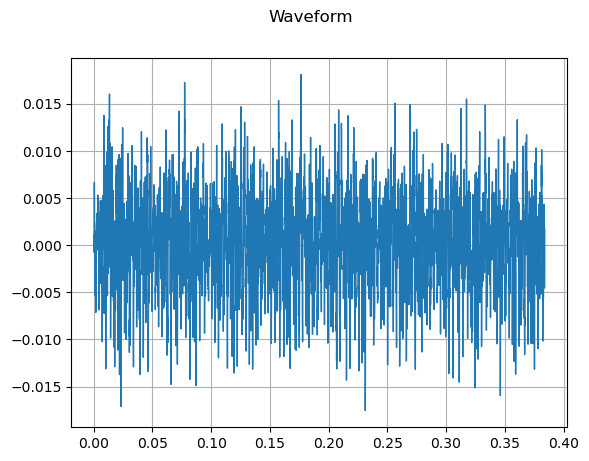

In [262]:
plot_waveform(test.flatten(0).unsqueeze(0).detach().numpy(), sr=16000)

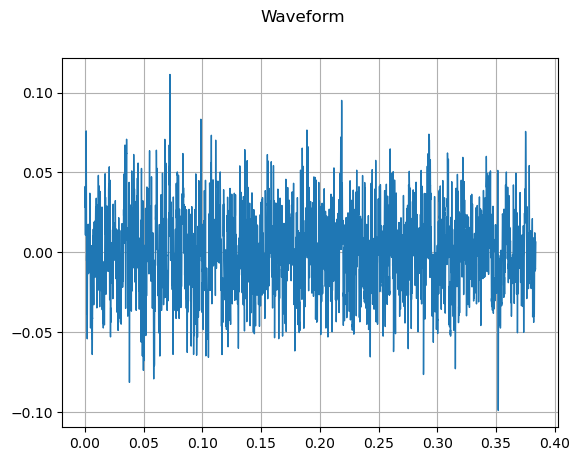

In [263]:
plot_waveform(test_y.flatten(0).unsqueeze(0).numpy(), sr=16000)

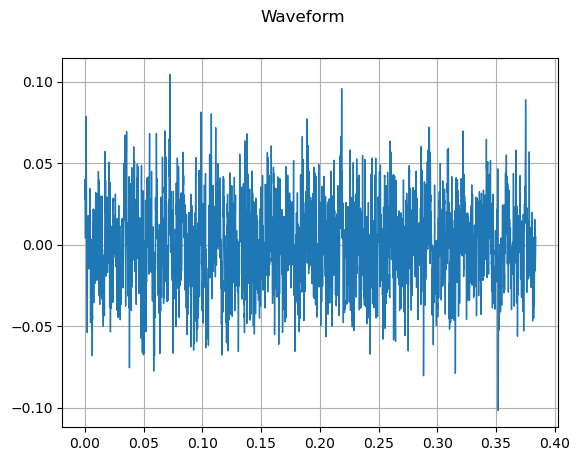

In [265]:
plot_waveform((test_y.flatten(0) - test.flatten(0).detach()).unsqueeze(0), sr=16000)

Pouze příklad použití, model není dostatečně vycvičen.